In [42]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Set display options for better readability
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set random seed for reproducibility
np.random.seed(42)

print("All required libraries imported successfully.")

All required libraries imported successfully.


In [43]:
import os 
import sys
path= os .path.abspath('../')
print(path)
if path not in sys.path:
   sys .path.append(path)

c:\Users\SOOQ ELASER\Desktop\diabetes_project\diabetes_project\data


In [44]:
# Import required libraries
import os
import sys
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options for better readability
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set random seed for reproducibility
np.random.seed(42)

print("All required libraries imported successfully.")

All required libraries imported successfully.


In [45]:
from src . data_preprocessor import Datapreprocessor

In [46]:
data = Datapreprocessor()

In [47]:
dataset = data.load_data('../Diabetes Missing Data.csv')

In [48]:
data.explore_data(dataset)


--- Dataset Overview ---
   Pregnant  Glucose  Diastolic_BP  Skin_Fold  Serum_Insulin   BMI  \
0         6   148.00         72.00      35.00            NaN 33.60   
1         1    85.00         66.00      29.00            NaN 26.60   
2         8   183.00         64.00        NaN            NaN 23.30   
3         1    89.00         66.00      23.00          94.00 28.10   
4         0   137.00         40.00      35.00         168.00 43.10   

   Diabetes_Pedigree  Age  Class  
0               0.63   50      1  
1               0.35   31      0  
2               0.67   32      1  
3               0.17   21      0  
4               2.29   33      1  

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Pregnant           768 non-null    int64  
 1   Glucose            763 non-null    float64
 2   Diastolic_BP       733 non-n

In [49]:
data.identify_issues(dataset)


--- Biological Impossibilities (Zeros) ---
Glucose: 0 zeros
BMI: 0 zeros

--- Data Types ---
Pregnant               int64
Glucose              float64
Diastolic_BP         float64
Skin_Fold            float64
Serum_Insulin        float64
BMI                  float64
Diabetes_Pedigree    float64
Age                    int64
Class                  int64
dtype: object

--- Potential Outliers (IQR method) ---
Glucose: 0 potential outliers
BMI: 8 potential outliers


In [50]:
# Comprehensive Biological Validation with Enhanced Error Handling
try:
    print("\n--- Comprehensive Biological Validation ---")
    
    # Store original row count for reference
    original_rows = len(dataset)
    print(f"Original number of records: {original_rows}")
    
    # 1. Check for biologically impossible values with more detailed ranges
    biochecks = {
        'Glucose': (70, 200),  # mg/dL (fasting glucose range)
        'Diastolic_BP': (40, 120),  # mm Hg
        'Skin_Fold': (5, 60),  # mm (triceps skin fold)
        'BMI': (15, 60),  # kg/m²
        'Serum_Insulin': (2, 480),  # pmol/L (converted from mu U/ml)
        'Age': (20, 100),  # years (for adult diabetes study)
        'Pregnant': (0, 15)  # Assuming reasonable upper limit for pregnancies
    }
    
    # 2. Check for negative values in all numeric columns
    numeric_cols = dataset.select_dtypes(include=[np.number]).columns
    negative_check = (dataset[numeric_cols] < 0).sum()
    if negative_check.any():
        print("\nNegative values found in the following columns:")
        print(negative_check[negative_check > 0])
    
    # 3. Check for biologically impossible values
    print("\n--- Checking for Biologically Impossible Values ---")
    for col, (min_val, max_val) in biochecks.items():
        if col in dataset.columns:
            invalid = ((dataset[col] < min_val) | (dataset[col] > max_val)).sum()
            if invalid > 0:
                print(f"{col}: {invalid} values outside biological range ({min_val}-{max_val})")
                # Store invalid indices for potential review
                invalid_idx = dataset[(dataset[col] < min_val) | (dataset[col] > max_val)].index
                print(f"   → Rows with invalid values: {list(invalid_idx)[:5]}{'...' if len(invalid_idx) > 5 else ''}")
                # Replace with NaN for later imputation
                dataset.loc[(dataset[col] < min_val) | (dataset[col] > max_val), col] = np.nan
                print(f"   → Replaced {invalid} invalid values with NaN for {col}")
    
    # 4. Check for biologically impossible combinations
    print("\n--- Checking for Implausible Value Combinations ---")
    # High glucose but low insulin (potential diabetes case)
    high_glucose = dataset['Glucose'] > 140  # mg/dL
    low_insulin = dataset['Serum_Insulin'] < 16  # pmol/L
    implausible = (high_glucose & low_insulin).sum()
    if implausible > 0:
        print(f"Found {implausible} cases of high glucose with low insulin (biologically implausible)")
    
    # Check for extreme BMI with normal skin fold
    high_bmi = dataset['BMI'] > 30  # Obese
    low_skinfold = dataset['Skin_Fold'] < 10  # Unusually low for obese
    implausible_bmi = (high_bmi & low_skinfold).sum()
    if implausible_bmi > 0:
        print(f"Found {implausible_bmi} cases of high BMI with low skin fold (potentially invalid data)")
    
    # 5. Additional validation for pregnancy
    if 'Pregnant' in dataset.columns and 'Age' in dataset.columns:
        pregnant_teens = ((dataset['Pregnant'] > 0) & (dataset['Age'] < 18)).sum()
        if pregnant_teens > 0:
            print(f"\nFound {pregnant_teens} cases of pregnancy under age 18")
    
    # 6. Check for missing values after validation
    print("\n--- Missing Values After Validation ---")
    missing_values = dataset.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    if len(missing_values) > 0:
        print(missing_values)
    else:
        print("No missing values found after validation.")
    
    # 7. Data type validation
    print("\n--- Data Type Validation ---")
    print(dataset.dtypes)
    
    # 8. Final data shape
    print("\n--- Final Data Shape ---")
    print(f"Rows: {dataset.shape[0]}, Columns: {dataset.shape[1]}")
    
    # 9. Calculate and report data loss
    final_rows = len(dataset)
    data_loss = original_rows - final_rows
    if data_loss > 0:
        print(f"\n⚠️  Data Loss: {data_loss} records removed during validation ({data_loss/original_rows*100:.2f}%)")
    else:
        print("\n✅ No data loss during validation.")
        
except Exception as e:
    print(f"\n❌ Error during biological validation: {str(e)}")
    # Re-raise the exception to stop execution
    raise

print("Biological validation completed.")


--- Comprehensive Biological Validation ---
Original number of records: 768

--- Checking for Biologically Impossible Values ---
Glucose: 11 values outside biological range (70-200)
   → Rows with invalid values: [62, 76, 146, 352, 520]...
   → Replaced 11 invalid values with NaN for Glucose
Diastolic_BP: 5 values outside biological range (40-120)
   → Rows with invalid values: [18, 106, 125, 597, 599]
   → Replaced 5 invalid values with NaN for Diastolic_BP
Skin_Fold: 2 values outside biological range (5-60)
   → Rows with invalid values: [445, 579]
   → Replaced 2 invalid values with NaN for Skin_Fold
BMI: 1 values outside biological range (15-60)
   → Rows with invalid values: [177]
   → Replaced 1 invalid values with NaN for BMI
Serum_Insulin: 12 values outside biological range (2-480)
   → Rows with invalid values: [8, 13, 111, 153, 186]...
   → Replaced 12 invalid values with NaN for Serum_Insulin
Pregnant: 1 values outside biological range (0-15)
   → Rows with invalid values: 


--- Enhanced Outlier Detection and Treatment ---

Processing column: Pregnant


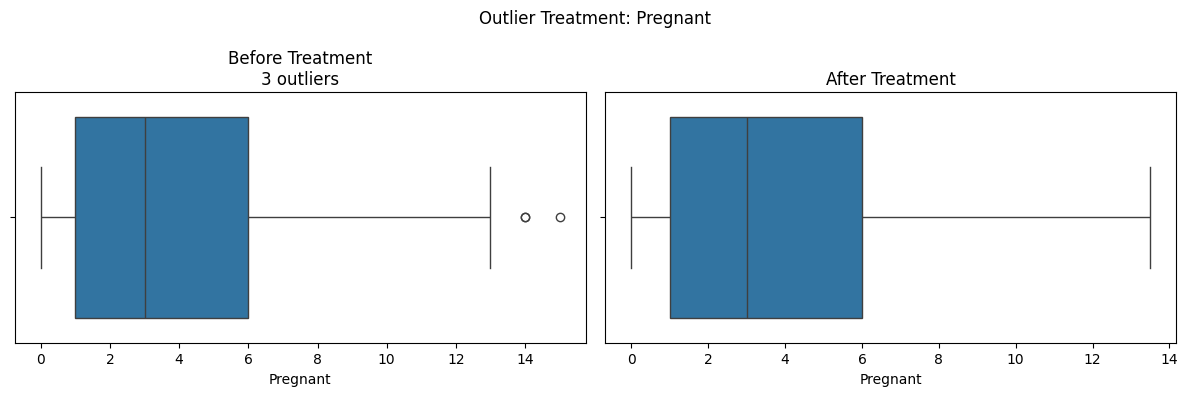

→ Treated 3 outliers in Pregnant

Processing column: Glucose


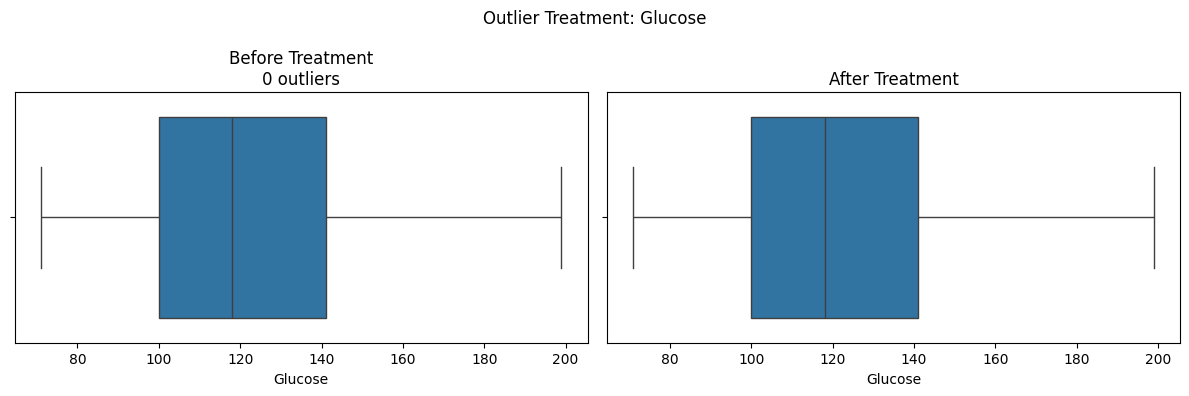

→ Treated 0 outliers in Glucose

Processing column: Diastolic_BP


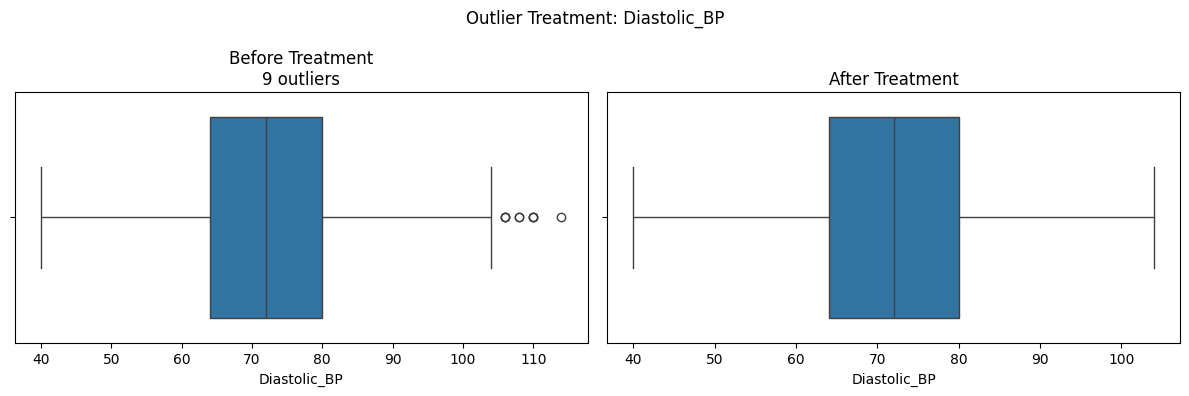

→ Treated 9 outliers in Diastolic_BP

Processing column: Skin_Fold


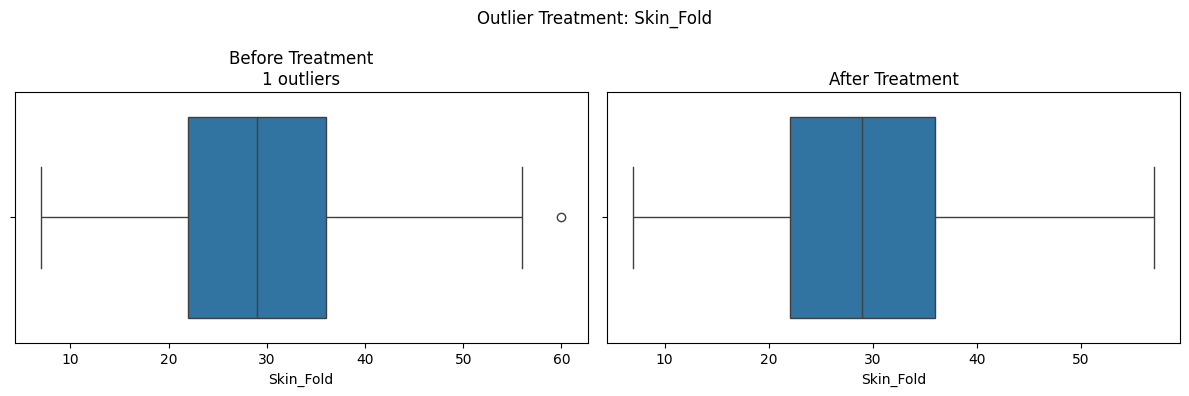

→ Treated 1 outliers in Skin_Fold

Processing column: Serum_Insulin


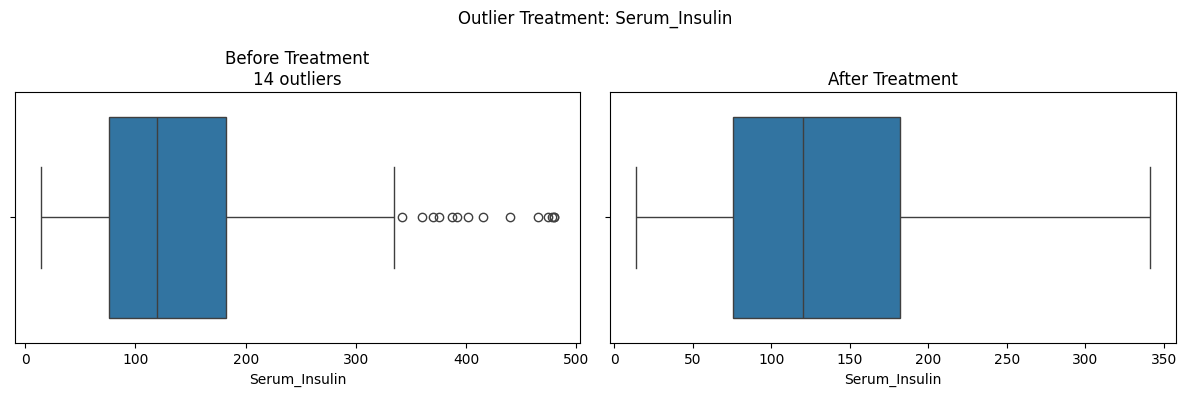

→ Treated 14 outliers in Serum_Insulin

Processing column: BMI


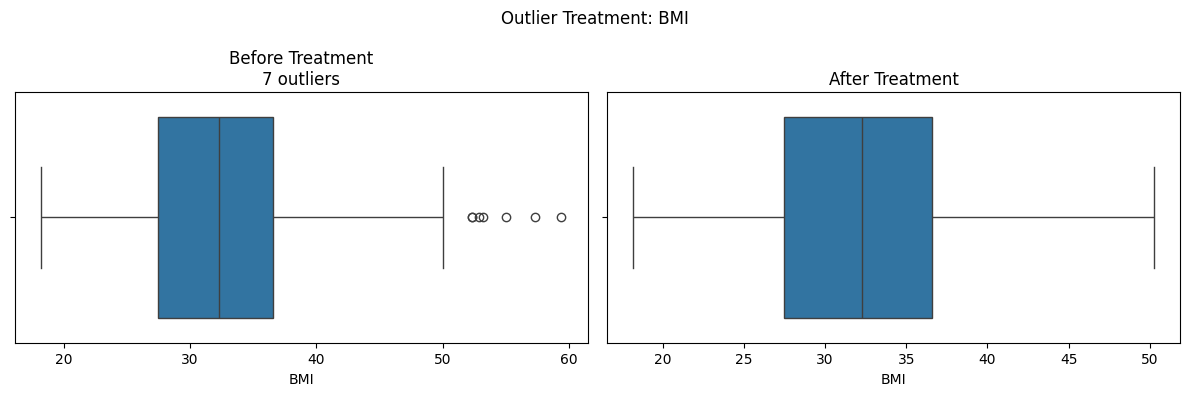

→ Treated 7 outliers in BMI

Processing column: Diabetes_Pedigree


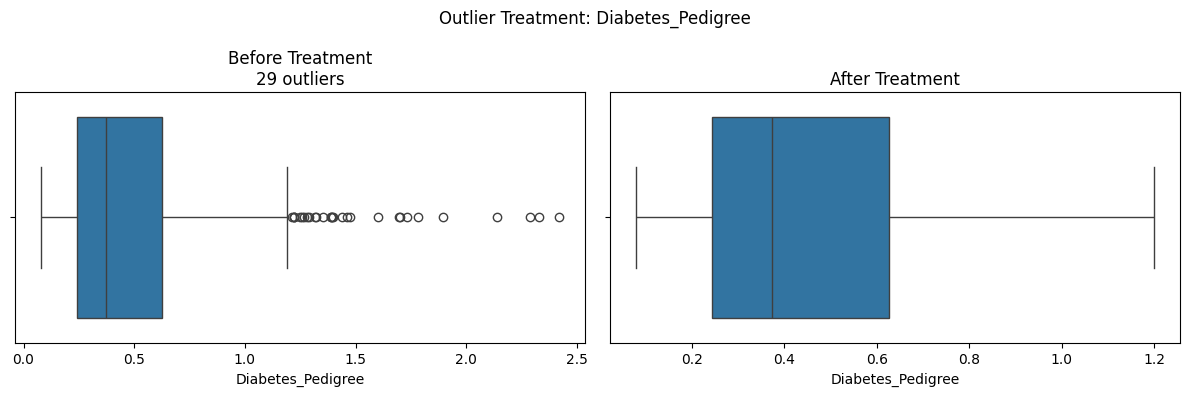

→ Treated 29 outliers in Diabetes_Pedigree

Processing column: Age


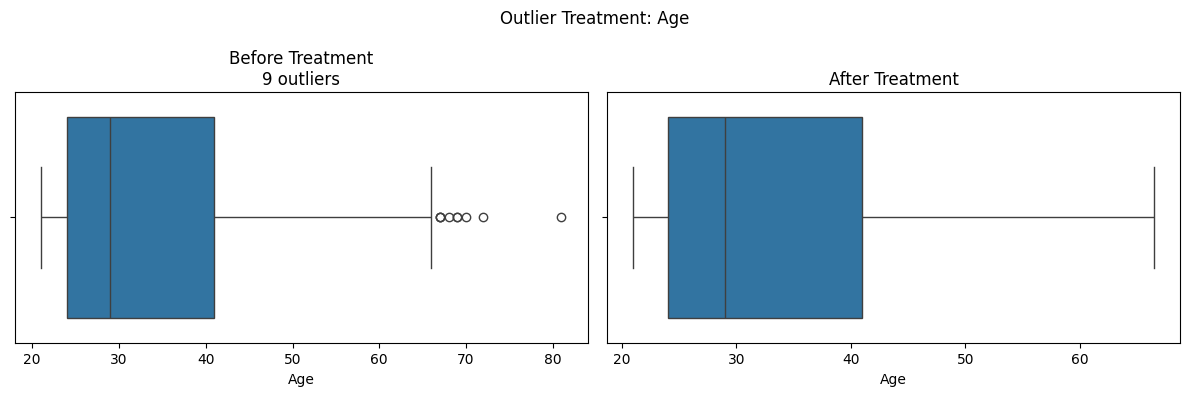

→ Treated 9 outliers in Age

--- Outlier Treatment Summary ---
Total outliers treated across all columns: 72

Outliers treated per column:
- Pregnant: 3 outliers
- Diastolic_BP: 9 outliers
- Skin_Fold: 1 outliers
- Serum_Insulin: 14 outliers
- BMI: 7 outliers
- Diabetes_Pedigree: 29 outliers
- Age: 9 outliers

--- Statistics Before and After Outlier Treatment ---

Original Statistics (before treatment):
                    min    25%    50%    75%    max
Pregnant           0.00   1.00   3.00   6.00  15.00
Glucose           71.00 100.00 118.00 141.00 199.00
Diastolic_BP      40.00  64.00  72.00  80.00 114.00
Skin_Fold          7.00  22.00  29.00  36.00  60.00
Serum_Insulin     14.00  76.00 120.00 182.00 480.00
BMI               18.20  27.50  32.30  36.60  59.40
Diabetes_Pedigree  0.08   0.24   0.37   0.63   2.42
Age               21.00  24.00  29.00  41.00  81.00

Updated Statistics (after treatment):
                    min    25%    50%    75%    max
Pregnant           0.00   1.00   3

In [51]:
# Enhanced Outlier Detection and Treatment with Visualization
try:
    print("\n--- Enhanced Outlier Detection and Treatment ---")
    
    # Select only numerical columns for outlier detection
    numerical_cols = dataset.select_dtypes(include=['int64', 'float64']).columns.tolist()
    # Remove target variable and other non-feature columns if needed
    if 'Class' in numerical_cols:
        numerical_cols.remove('Class')
    
    # Store original statistics
    original_stats = dataset[numerical_cols].describe()
    
    # Function to detect and treat outliers using IQR with visualization
    def treat_outliers(df, column):
        # Calculate statistics
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Count outliers
        outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
        
        # Create before/after visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f'Outlier Treatment: {column}')
        
        # Before treatment
        sns.boxplot(x=df[column], ax=ax1)
        ax1.set_title(f'Before Treatment\n{outliers} outliers')
        
        # Cap the outliers at the bounds
        df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
        df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
        
        # After treatment
        sns.boxplot(x=df[column], ax=ax2)
        ax2.set_title('After Treatment')
        
        plt.tight_layout()
        plt.show()
        
        return df, outliers
    
    # Apply outlier treatment to all numerical columns
    total_outliers = 0
    outlier_report = {}
    
    for col in numerical_cols:
        print(f"\nProcessing column: {col}")
        try:
            dataset, num_outliers = treat_outliers(dataset.copy(), col)
            outlier_report[col] = num_outliers
            total_outliers += num_outliers
            print(f"→ Treated {num_outliers} outliers in {col}")
        except Exception as e:
            print(f"⚠️  Error processing {col}: {str(e)}")
            continue
    
    # Show summary of outlier treatment
    print("\n--- Outlier Treatment Summary ---")
    print(f"Total outliers treated across all columns: {total_outliers}")
    print("\nOutliers treated per column:")
    for col, count in outlier_report.items():
        if count > 0:
            print(f"- {col}: {count} outliers")
    
    # Show before/after statistics
    print("\n--- Statistics Before and After Outlier Treatment ---")
    print("\nOriginal Statistics (before treatment):")
    print(original_stats.T[['min', '25%', '50%', '75%', 'max']])
    
    print("\nUpdated Statistics (after treatment):")
    print(dataset[numerical_cols].describe().T[['min', '25%', '50%', '75%', 'max']])
    
    # Check for remaining outliers
    remaining_outliers = 0
    for col in numerical_cols:
        Q1 = dataset[col].quantile(0.25)
        Q3 = dataset[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        remaining = ((dataset[col] < lower_bound) | (dataset[col] > upper_bound)).sum()
        remaining_outliers += remaining
    
    if remaining_outliers > 0:
        print(f"\n⚠️  Note: {remaining_outliers} potential outliers remain after treatment")
    else:
        print("\n✅ All potential outliers have been treated.")
    
except Exception as e:
    print(f"\n❌ Error during outlier detection: {str(e)}")
    # Re-raise the exception to stop execution
    raise

print("\nOutlier detection and treatment completed.")


--- Missing Value Percentages ---
Pregnant             0.13
Glucose              2.08
Diastolic_BP         5.21
Skin_Fold           29.82
Serum_Insulin       50.26
BMI                  1.56
Diabetes_Pedigree    0.00
Age                  0.00
Class                0.00
dtype: float64

--- Missing Data Matrix ---


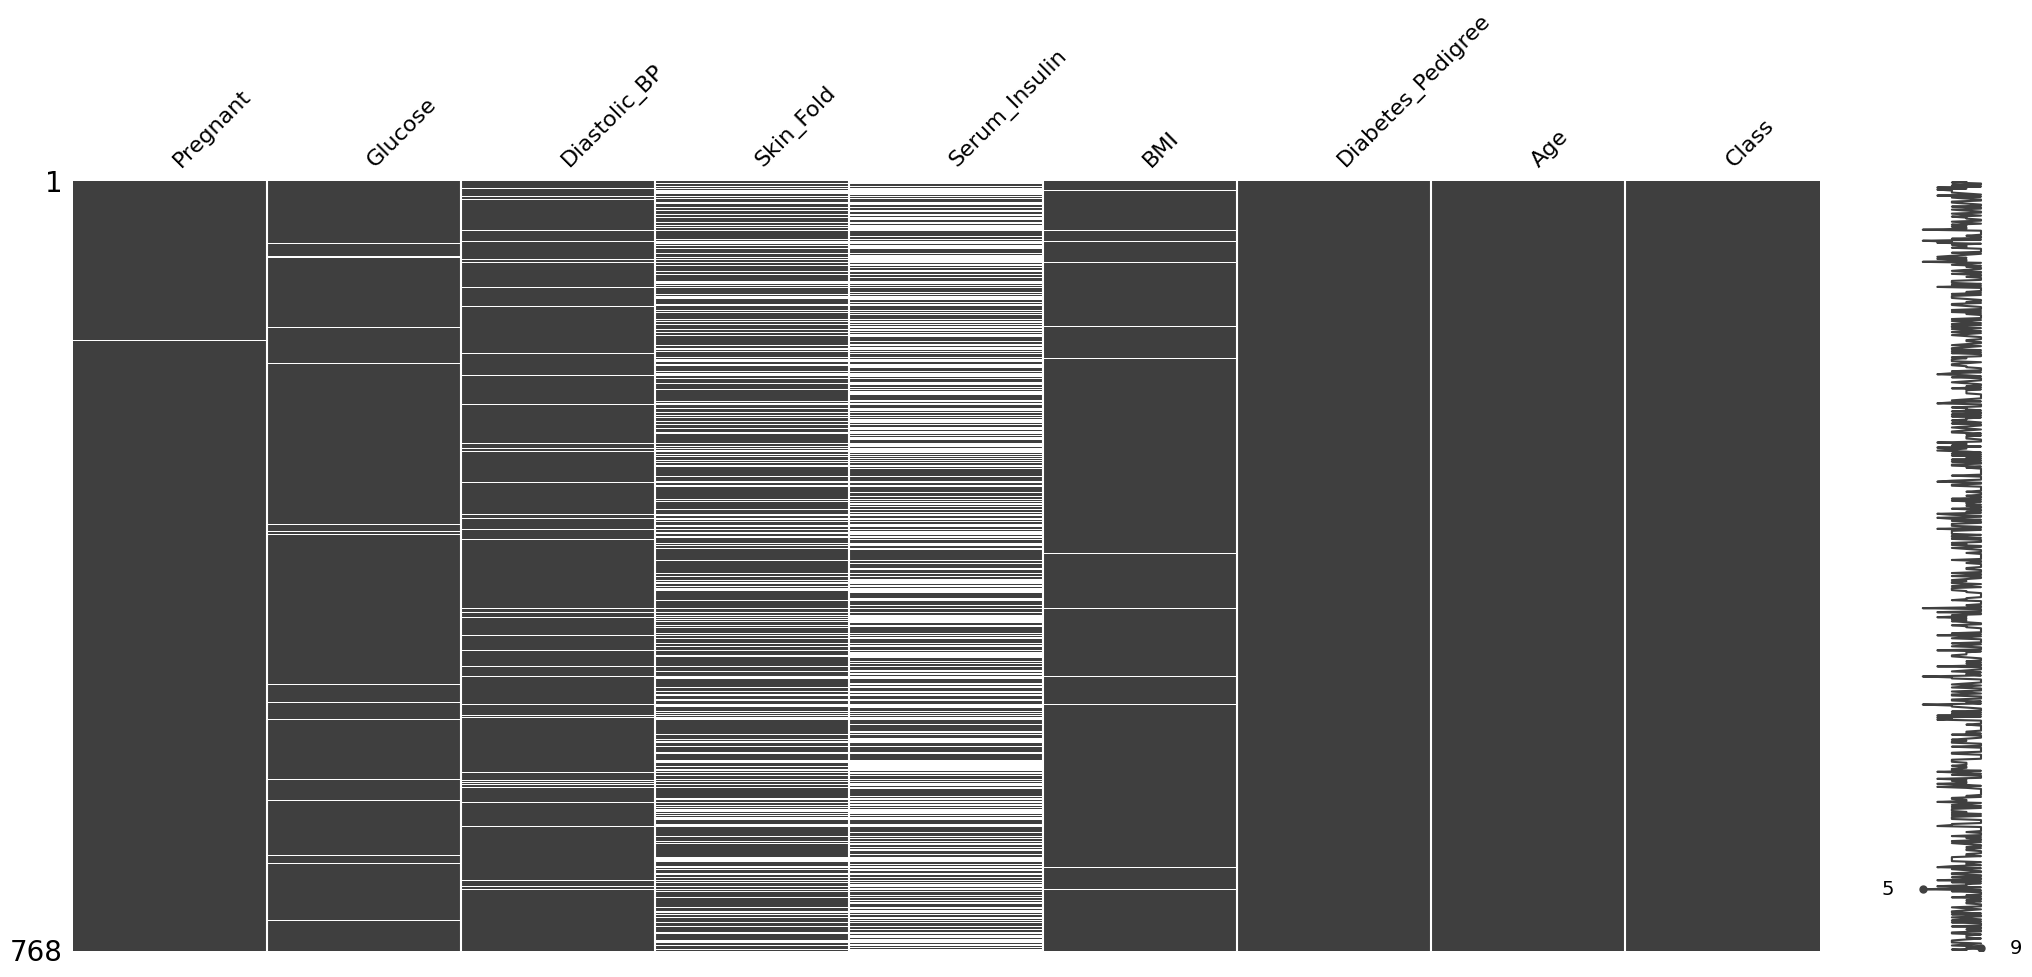


--- Missing Data Heatmap ---


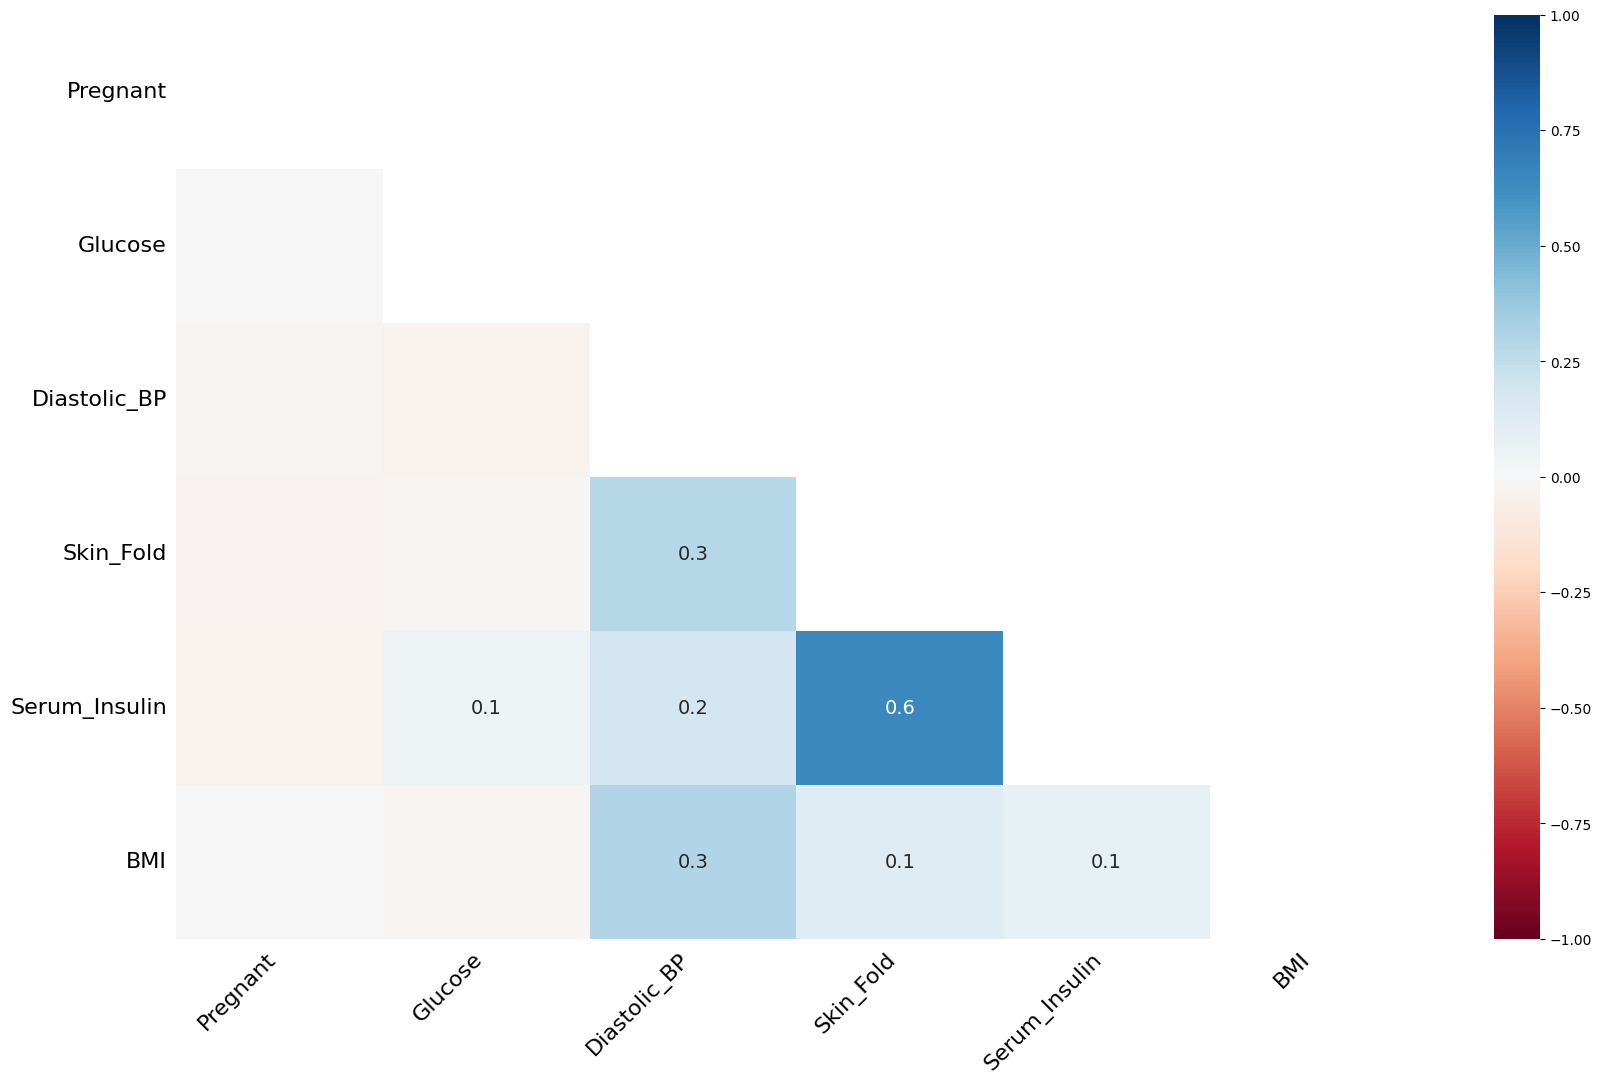

In [52]:
dataset = data.missing_value_analysis(dataset)


In [53]:
dataset = data.impute_missing(dataset, strategy='median')

In [54]:
dataset = data.feature_engineering(dataset)


In [55]:
dataset = data.encode_features(dataset)

In [56]:
dataset = data.scale_features(dataset, method='standard')

In [57]:
print(dataset.head())

   Pregnant  Glucose  Diastolic_BP  Skin_Fold  Serum_Insulin   BMI  \
0      0.65     0.86         -0.04       0.73          -0.16  0.19   
1     -0.85    -1.27         -0.57       0.00          -0.16 -0.87   
2      1.26     2.05         -0.74       0.00          -0.16 -1.37   
3     -0.85    -1.13         -0.57      -0.72          -0.61 -0.64   
4     -1.15     0.49         -2.85       0.73           0.66  1.62   

   Diabetes_Pedigree   Age  Class  AgeGroup  BMICategory  GlucoseCategory  
0               0.59  1.45   1.37     -1.40        -0.18             1.70  
1              -0.38 -0.19  -0.73      0.74         1.45            -0.59  
2               0.75 -0.10   1.37      0.74        -1.82             1.70  
3              -1.02 -1.05  -0.73      0.74         1.45            -0.59  
4               2.60 -0.02   1.37      0.74        -0.18            -0.59  


In [58]:
dataset.columns = dataset.columns.str.strip()  # remove any spaces
target_col = dataset.columns[-1]  # last column assumed to be target
print(f"Detected target column: {target_col}")

Detected target column: GlucoseCategory


In [59]:
X = dataset.drop(target_col, axis=1)
y = dataset[target_col]


In [60]:
if y.dtype != int:
    y = y.astype(int)
print(y.dtype, y.unique())

int64 [1 0]


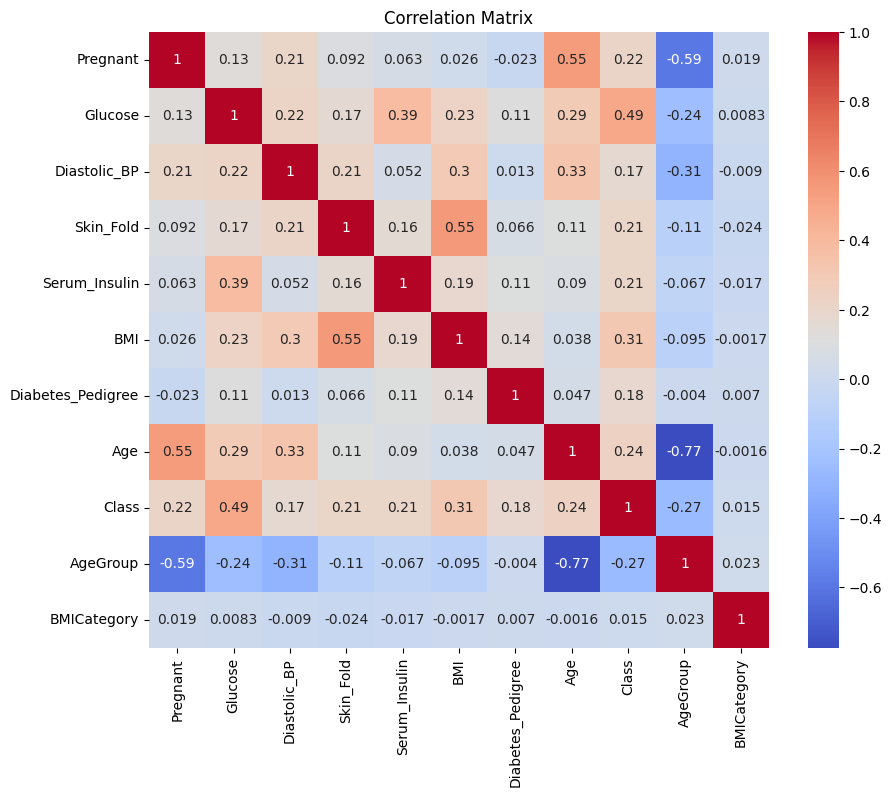

Top 5 features selected by mutual information: ['Glucose', 'Diastolic_BP', 'Serum_Insulin', 'Age', 'Class']


In [61]:
data.correlation_matrix(X)
top_features = data.select_k_best_features(X, y, k=5)
X_selected = X[top_features]

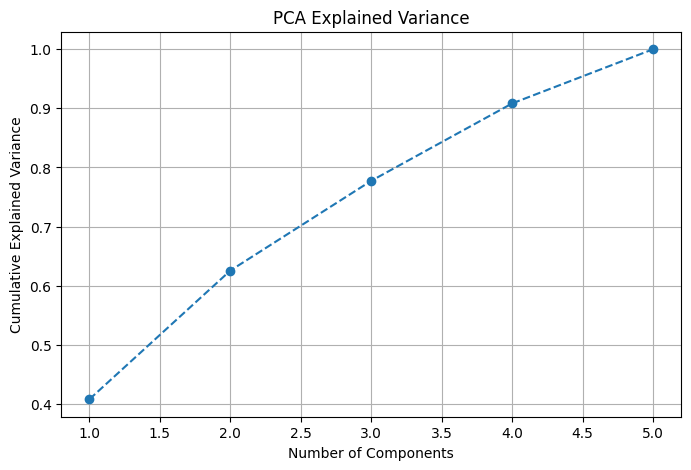

Explained variance by component: [0.40793398 0.21766327 0.15184388 0.1308874  0.09167146]


In [62]:
X_pca, explained_var, cum_var = data.perform_pca(X_selected)

Class distribution:
 GlucoseCategory
0    571
1    197
Name: count, dtype: int64
Imbalance ratio (minority/majority): 0.35


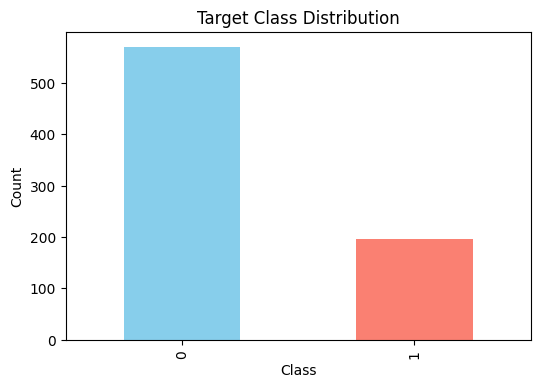

np.float64(0.3450087565674256)

In [63]:
data.analyze_class_distribution(y)

In [64]:
# Save the cleaned and processed dataset to a CSV file
output_path = 'cleaned_diabetes_data.csv'
dataset.to_csv(output_path, index=False)
print(f"Cleaned dataset saved to: {output_path}")

Cleaned dataset saved to: cleaned_diabetes_data.csv


In [65]:
# Save the final processed dataset after all transformations
output_path = 'cleaned_diabetes_data.csv'
dataset.to_csv(output_path, index=False)
print(f"Final processed dataset saved to: {output_path}")

# Now balance the data (this is separate from the saved dataset)
X_balanced, y_balanced = data.balance_data(X_selected, y)

Final processed dataset saved to: cleaned_diabetes_data.csv
Class distribution after balancing:
 GlucoseCategory
1    571
0    571
Name: count, dtype: int64
